Имеется 400 избражений лиц, 200 мужчин и 200 женщин. Нужно построить модель, которая по изображению будет определять пол человека. В качестве тестовой выборки есть по 100 изображений лиц каждого пола.

***#1.*** Загрузим необходимые библиотеки

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from matplotlib.pyplot import subplots

In [2]:
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, roc_curve, roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

In [3]:
import torch
import random
import torchvision 
from torchvision import transforms, models

In [4]:
#для работы с папками и файлами
import os
import shutil
from tqdm import tqdm

# LBP преобразование и логистическая регрессия

In [5]:
train_dir = 'train'
val_dir = 'val'
test_dir = 'test'

class_names = ['M', 'W']

data_root = './face'
os.listdir(data_root)

['test', 'train']

In [6]:
#создадим папки
for dir_name in [train_dir, val_dir]:
    for class_n in class_names:
        os.makedirs(os.path.join(dir_name, class_n), exist_ok = True)
        
#Делаем разбивку данных, на обучение и валидацию (понадобится для нейросетевых моделей). 
#В валидацию будет попадать каждое пятое изображение.
for class_n in class_names: 
    source_dir = os.path.join(data_root, 'train', class_n)
    for i, file_name in enumerate(tqdm(os.listdir(source_dir))):
        if i%5 != 0:
            dest_dir = os.path.join(train_dir, class_n)
        else:
            dest_dir = os.path.join(val_dir, class_n)
        shutil.copy(os.path.join(source_dir, file_name), os.path.join(dest_dir, file_name))

100%|███████████████████████████████████████| 200/200 [00:00<00:00, 306.26it/s]


***#2*** напишем функцию для LBP преобразования (локального двоичного разбиения)

In [7]:
def LBP(image):
    try:
        image_array = np.array(image)
        lbp_array = np.zeros(image_array.shape)
    
        for i in range(1, image_array.shape[0]-1):
            for j in range(1, image_array.shape[1]-1):
            
                if image_array[i-1, j-1] < image_array[i,j]:
                    a1 = 0
                else:
                    a1 = 1
                
                if image_array[i-1, j] < image_array[i,j]:
                    a2 = 0
                else:
                    a2 = 1

                if image_array[i-1, j+1] < image_array[i,j]:
                    a3 = 0
                else:
                    a3 = 1

                if image_array[i, j-1] < image_array[i,j]:
                    a4 = 0
                else:
                    a4 = 1

                if image_array[i, j+1] < image_array[i,j]:
                    a5 = 0
                else:
                    a5 = 1

                if image_array[i+1, j-1] < image_array[i,j]:
                    a6 = 0
                else:
                    a6 = 1

                if image_array[i+1, j] < image_array[i,j]:
                    a7 = 0
                else:
                    a7 = 1

                if image_array[i+1, j+1] < image_array[i,j]:
                    a8 = 0
                else:
                    a8 = 1
                
                lbp_array[i, j] = (a1*(2**7))+(a2*(2**6))+(a3*(2**5))+(a4*(2**4))+(a5*(2**3))+(a6*(2**2))+(a7*2)+a8
        return lbp_array
    
    except:
        print('ERROR in "LBP"!!!')

***#3*** Разобьем изображение на 5 на 5 прямоугольных областейдля каждой области вычислим число пикселей у которых интенсивность равна заданному числу из диапазона от 0 до 255 (для уменьшения пространства признаков мы этот диапазон разобьем на 10 частей и будем вычислять число пикселей у которых интенсивность равна заданному диапазону).

In [8]:
def imhist_5(image, h_left, h_right, w_left, w_right):
    try:
        D = np.zeros(10) #

        for i in range(h_left, h_right):
            for j in range (w_left, w_right):
            
                if (image[i,j] < 26 and image[i,j]  >= 0 ):
                    D[0] += 1

                if (image[i,j]  < 52 and image[i,j]  >= 26 ):
                    D[1] += 1

                if (image[i,j]  < 78 and image[i,j]  >= 52 ):
                    D[2] += 1

                if (image[i,j]  < 104 and image[i,j]  >= 78 ):
                    D[3] += 1

                if (image[i,j]  < 130 and image[i,j]  >= 104 ):
                    D[4] += 1

                if (image[i,j]  <= 155 and image[i,j]  >= 130 ):
                    D[5] += 1

                if (image[i,j]  <= 180 and image[i,j]  > 155 ):
                    D[6] += 1

                if (image[i,j]  <= 205 and image[i,j]  > 180 ):
                    D[7] += 1

                if (image[i,j]  <= 230 and image[i,j]  > 205 ):
                    D[8] += 1

                if (image[i,j]  <= 255 and image[i,j]  > 230 ):
                    D[9] += 1
        return D
    
    except:
        print('ERROR in "imhist_5"!!!')

***#4.*** Реализуем функциию, которая будет ставить изображение в соответствие вектор признак (размерность 5*5*10) 

In [9]:
def extract_features_lbp(image_lbp):
    try:
        dw = 22
        dh = 23
    
        #ans = np.zeros((1,1))
    
        for k in range(5):
        
            if k == 0:
                h_left = 0
            else:
                h_left = h_right

            h_right = k*dh
        
            for t in range(5):
            
                if t == 0:
                    w_left = 0
                else:
                    w_left = w_right
        
                w_right = t*dw
        
                if k == 0 and t == 0:
                
                    ans = imhist_5(image_lbp, h_left, h_right, w_left, w_right)
                
                else:
                    ans = np.concatenate((ans, imhist_5(image_lbp, h_left, h_right, w_left, w_right)))
        return ans
    
    except:
        print('ERROR in "extract_features_lbp"!!!')

***#5.*** Протестируем работу функций

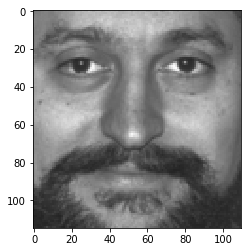

In [10]:
image_test = Image.open(os.path.join(data_root, train_dir, class_names[0], 
                                     os.listdir(os.path.join(data_root, train_dir, class_names[0]))[152]))
plt.imshow(image_test)
plt.show()

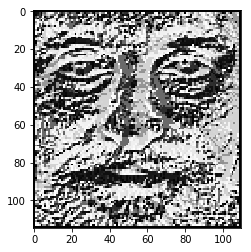

In [11]:
lbp_I = LBP(image_test)
plt.imshow(lbp_I, cmap='gray')
plt.show()

In [12]:
proba = extract_features_lbp(lbp_I)
proba.shape

(250,)

***#6.*** Напишем функцию для преобразования изображений в датасет

In [13]:
def extract_in_folder(name_folder, class_names):
    try:
        df = pd.DataFrame()

        for class_n in class_names: 
            for i, file_name in enumerate(tqdm((os.listdir(os.path.join(name_folder, class_n))))):
                image = Image.open(os.path.join(name_folder, class_n,file_name))
            
                new = LBP(image)
                new_2 = extract_features_lbp(new)
            
                tmp = pd.DataFrame([new_2])
                if class_n == 'W':
                    tmp['is_woman'] = 1
                else:
                    tmp['is_woman'] = 0
                
                tmp['name'] = file_name
            
                df = pd.concat([df, tmp])
            
        return df.sample(frac = 1, random_state = 100).reset_index(drop=True)
    
    except:
        print('ERROR in "extract_in_folder"!!!')

***#7.*** Сформируем датасеты

In [14]:
train = extract_in_folder(os.path.join(data_root, train_dir), class_names)
print(train.shape)

100%|████████████████████████████████████████| 200/200 [00:36<00:00,  5.49it/s]

(400, 252)


In [15]:
test = extract_in_folder(os.path.join(data_root, test_dir), class_names)
print(test.shape)

100%|████████████████████████████████████████| 100/100 [00:16<00:00,  6.13it/s]

(200, 252)


***#8*** Извлекем признаки и отделим целевой

In [16]:
features_train = train.drop(['is_woman', 'name'], axis=1)
target_train = train['is_woman']

features_test = test.drop(['is_woman', 'name'], axis=1)
target_test = test['is_woman']

***#9*** Отмасштабируем данные

In [17]:
scale = StandardScaler()

In [18]:
scale.fit(features_train)
features_train.head()

,0,1,2,3,4,5,6,7,8,9,...,240,241,242,243,244,245,246,247,248,249
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,72.0,41.0,8.0,5.0,69.0,20.0,5.0,13.0,45.0,228.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,113.0,92.0,12.0,8.0,45.0,22.0,7.0,7.0,51.0,149.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,72.0,43.0,11.0,8.0,74.0,49.0,6.0,8.0,38.0,197.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,58.0,45.0,11.0,5.0,68.0,63.0,2.0,11.0,55.0,188.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,72.0,44.0,10.0,11.0,52.0,46.0,9.0,18.0,52.0,192.0


In [19]:
features_train = pd.DataFrame(scale.transform(features_train))
features_test = pd.DataFrame(scale.transform(features_test))

features_train.head()

,0,1,2,3,4,5,6,7,8,9,...,240,241,242,243,244,245,246,247,248,249
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.556721,-0.721941,-1.153641,-1.033020,0.811123,-0.664677,-0.938506,-0.200902,-0.323737,1.079573
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.037522,2.311551,-0.500020,-0.245957,-0.389799,-0.516848,-0.429831,-1.165232,0.061664,-1.041185
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.556721,-0.602981,-0.663425,-0.245957,1.061315,1.478846,-0.684168,-1.004510,-0.773372,0.247377
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-1.101097,-0.484020,-0.663425,-1.033020,0.761084,2.513650,-1.701519,-0.522345,0.318598,0.005772
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.556721,-0.543501,-0.826830,0.541106,-0.039530,1.257102,0.078845,0.602706,0.125898,0.113152


***#10.*** Обучим модель логистической регрессии. Т.к. классы сбалансированы и не отдается препочтение какому-либо из них, то в качестве метрики будем использовать ***accuracy***

In [20]:
log_reg = LogisticRegression(random_state=100)

In [21]:
params = {'C': np.linspace(0.001,1.0,55)}

#scoring по умолчанию accurancy
gs = GridSearchCV(estimator = log_reg, 
                      param_grid = params, 
                      cv = 5, 
                      scoring = 'accuracy', 
                      n_jobs=-1
)

In [22]:
gs.fit(features_train, target_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=100, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'C': array([0.001 , 0.0195, 0.038 , 0.0565, 0.075 , 0.0935, 0.112 , 0.1305,
       0.149 , 0.1675, 0.186 , 0.2045, 0.223 , 0.2415, 0.26  , 0.2785,
       0.297 , 0.3155, 0.334 , 0.3525, 0.371 , 0.3895, 0.408 , 0.4265,
       0.445 , 0.4635, 0.482 , 0.5005, 0.519 , 0.5375, 0.556 , 0.5745,...65, 0.815 , 0.8335, 0.852 , 0.8705,
       0.889 , 0.9075, 0.926 , 0.9445, 0.963 , 0.9815, 1.    ])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=0)

In [23]:
print('Лучшие гиперпараметры: ', gs.best_params_)
print('Лучший score на тренировочной выборке: ', gs.best_score_)

Лучшие гиперпараметры:  {'C': 0.0935}
Лучший score на тренировочной выборке:  0.915


In [24]:
log_reg = gs.best_estimator_

In [25]:
#Проверка на тесте
predicted = log_reg.predict(features_test)

print('\naccuracy на тестовой выборке: ', accuracy_score(target_test, predicted))


accuracy на тестовой выборке:  0.855


In [26]:
print('Число неправильных классификаций', np.abs(target_test-predicted).sum())

Число неправильных классификаций 29


In [27]:
#функция для построения roc-кривой и AUC метрики
def ROC_curve_AUC(model, features, target):
    try:
        model.predict(features)
        score_one = model.predict_proba(features)[:, 1]
        auc_roc = round(roc_auc_score(target, score_one), 4)
    
        fpr, tpr, thresholds = roc_curve(target, score_one)

        plt.figure(figsize=(6,6))
        plt.plot(fpr, tpr)

        # ROC-кривая случайной модели
        plt.plot([0, 1], [0, 1], linestyle='--')

        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.0])

        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')

        plt.title('ROC-кривая, AUC = '+str(auc_roc))
        plt.show()

    except:
        print('ERROR in "ROC_curve_AUC"!!!')

***#11*** Построим ROC-кривую и вычислим ROC-AUC

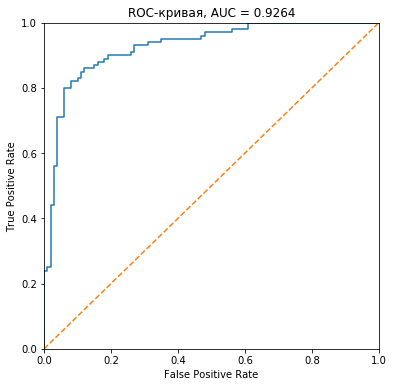

In [28]:
ROC_curve_AUC(log_reg, features_test, target_test)

In [29]:
#список файлов с ошибкой в классификации
predicted = pd.Series(predicted)
test.loc[(target_test - predicted).abs() > 0]['name'].sort_values()

11     1331.png
0      1333.png
175    1337.png
72     1355.png
32     1358.png
58     1359.png
51     1360.png
33     1369.png
139    1373.png
5      1374.png
40     1375.png
56     1399.png
124    1400.png
127     206.png
44      208.png
77      211.png
145     214.png
154     228.png
143     231.png
128     237.png
93      238.png
90      252.png
188     254.png
153     257.png
70      258.png
9       270.png
138     279.png
194     280.png
2       300.png
Name: name, dtype: object

#### Проверим на собственном фото работу модели

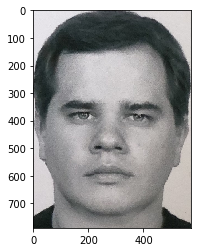

(573, 789)

In [30]:
i = Image.open('tim.jpg')
plt.imshow(i, cmap = plt.get_cmap('gray'))
plt.show()

size = (110, 115)
gray = i.convert('L')
gray.size

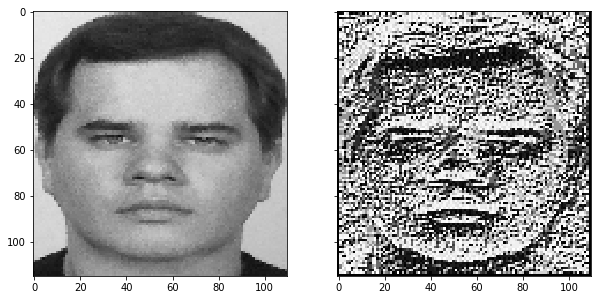

Мужчина


In [31]:
gray = gray.resize(size)
img = LBP(gray)

fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize = (10, 5))
ax1.imshow(gray, cmap = plt.get_cmap('gray'))
ax2.imshow(img, cmap = plt.get_cmap('gray'))
plt.show()

proba = pd.DataFrame([extract_features_lbp(img)])

if log_reg.predict(proba) == 0:
    print('Мужчина')
else:
    print('Женщина')

### Вывод  
Получили значение метрики 85.5% на тесте. Будем отталкиваться от этого значения при использовании нейросетевых моделей.

# MY LeNet

In [32]:
random.seed(0)
np.random.seed(0)
torch.manual_seed(0)
torch.cuda.manual_seed(0)
torch.backends.cudnn.deterministic = True

***#12*** Загрузим изображения из папок, используя Dataloader 

In [33]:
#train
train_transforms = transforms.Compose([
    transforms.Resize((28, 28)), #уменьшим размер, как в классической LeNet + это ускоряет расчет
    transforms.Grayscale(),
    transforms.ToTensor()
])


train_dataset = torchvision.datasets.ImageFolder(train_dir, train_transforms)
val_dataset = torchvision.datasets.ImageFolder(val_dir, train_transforms)
test_dataset = torchvision.datasets.ImageFolder(test_dir, train_transforms)

#batch = 10
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=320, shuffle=True)

val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=80, shuffle=True)

test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=200, shuffle=False)

In [34]:
len(train_dataloader), len(test_dataloader), len(val_dataloader)

(1, 1, 1)

***#13*** Посмотрим на изображение

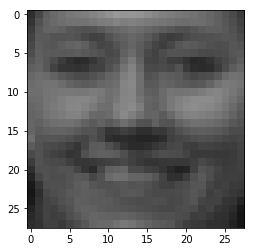

In [35]:
X_batch, y_batch = next(iter(val_dataloader))
mean = np.array([0.0, 0.0, 0.0])
std = np.array([1, 1, 1])
plt.imshow(X_batch[0].permute(1, 2, 0).numpy() * std + mean)
plt.show()

***#14*** Напишем функцию для построения изображений

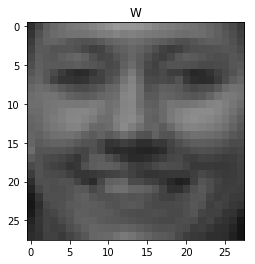

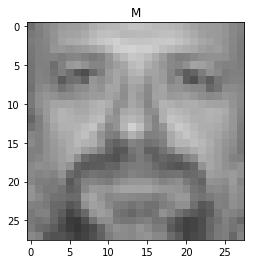

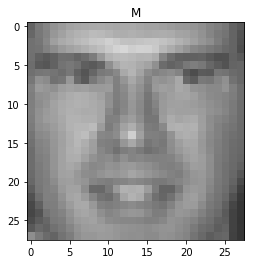

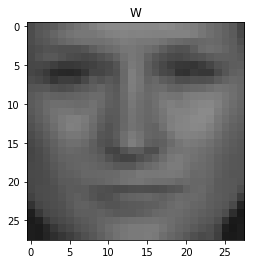

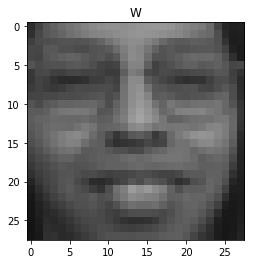

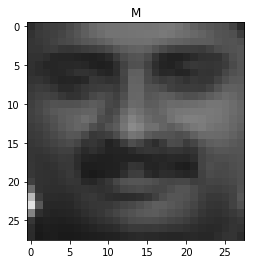

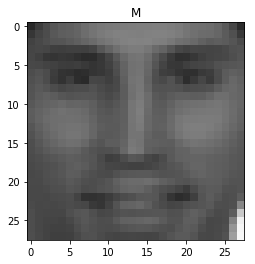

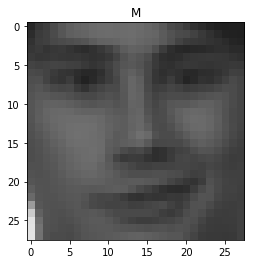

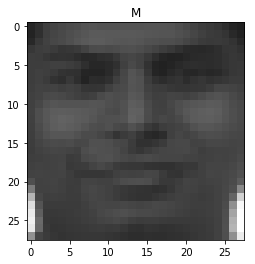

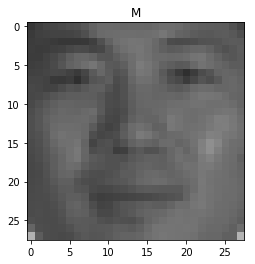

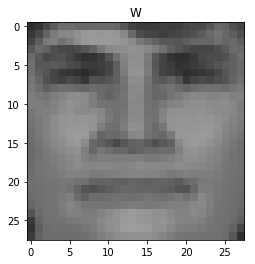

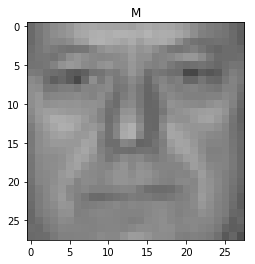

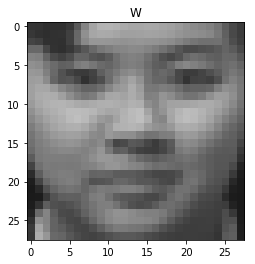

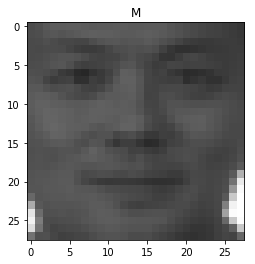

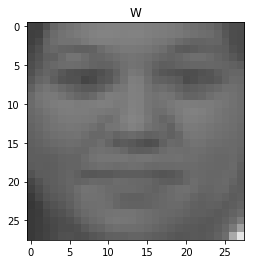

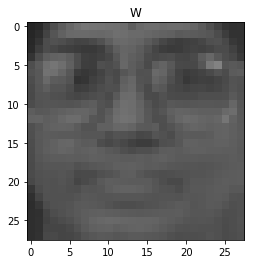

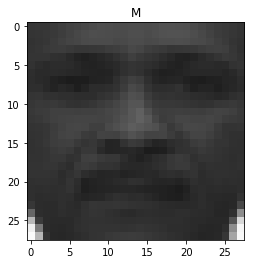

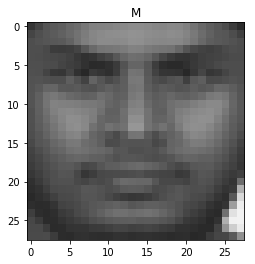

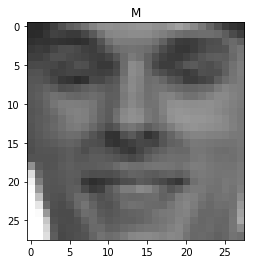

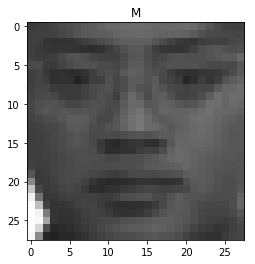

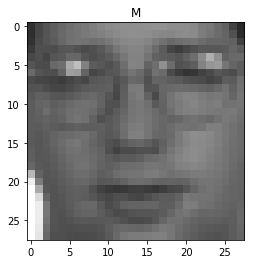

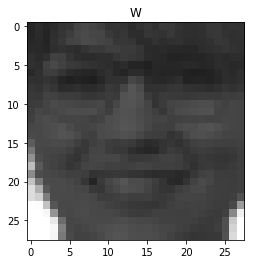

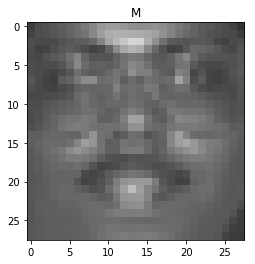

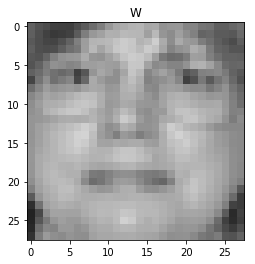

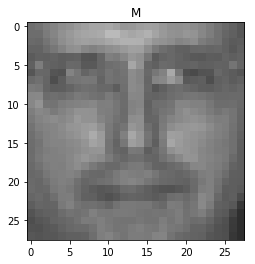

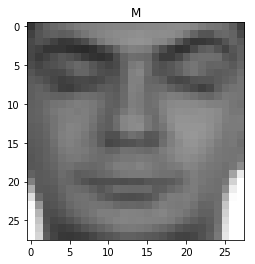

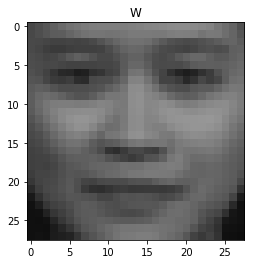

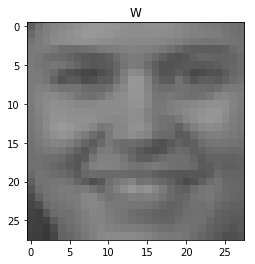

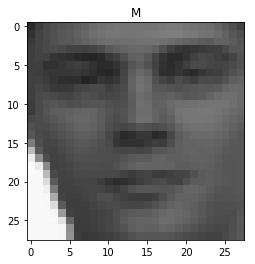

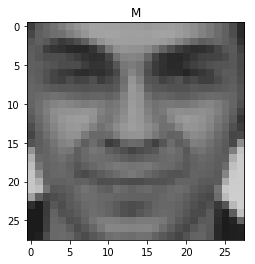

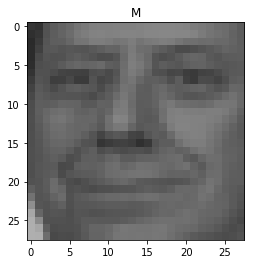

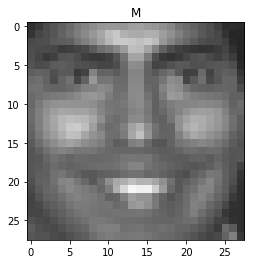

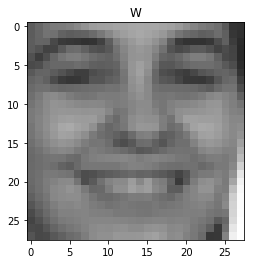

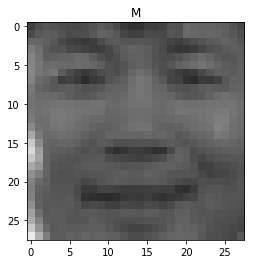

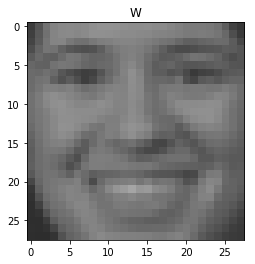

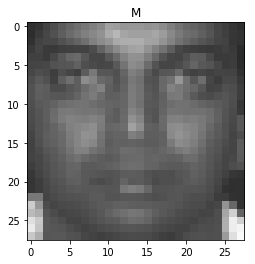

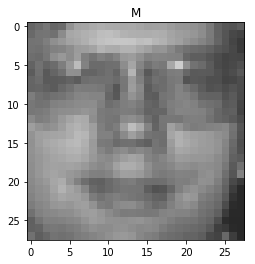

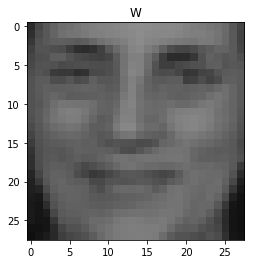

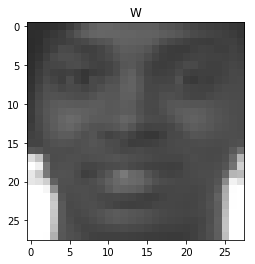

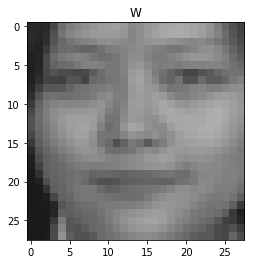

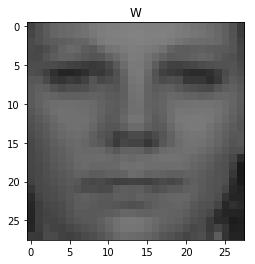

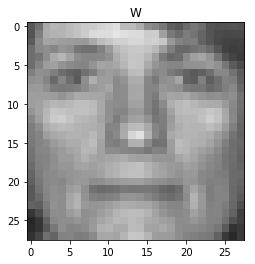

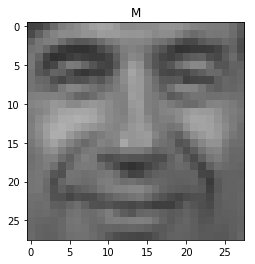

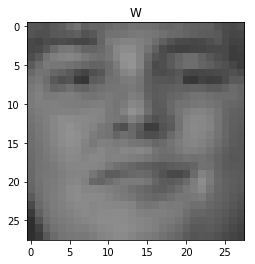

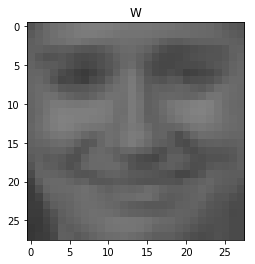

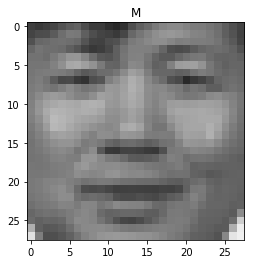

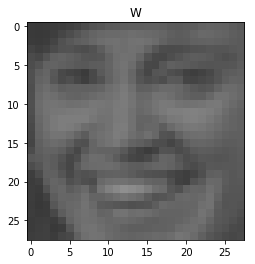

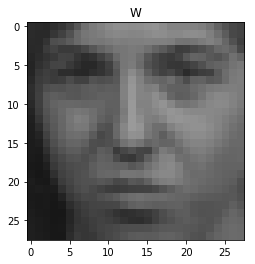

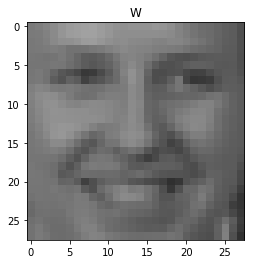

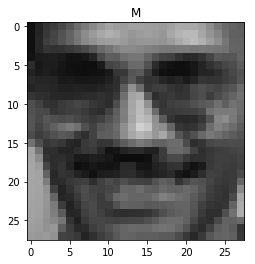

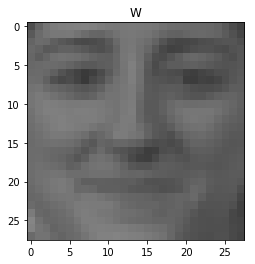

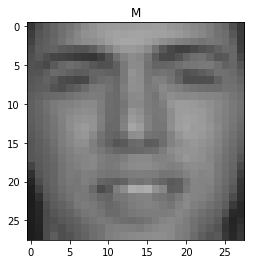

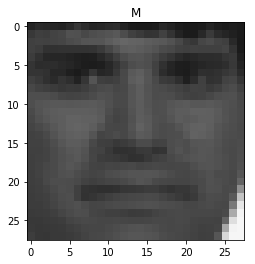

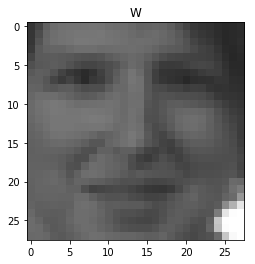

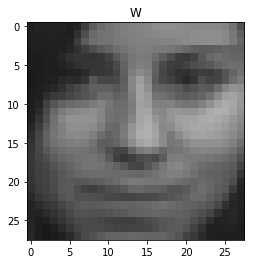

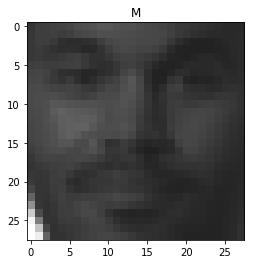

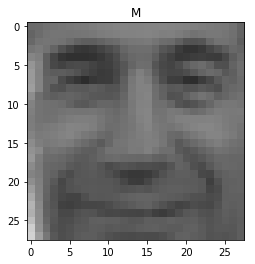

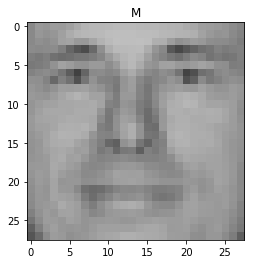

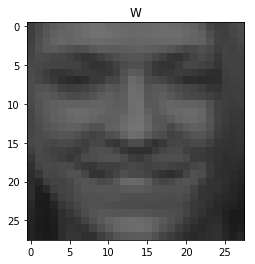

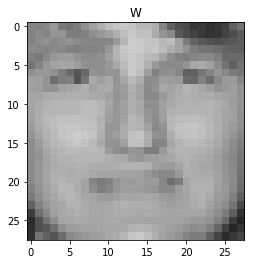

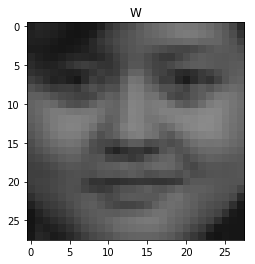

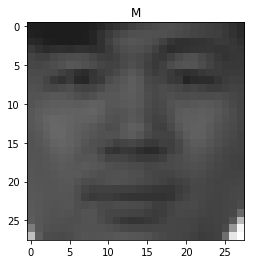

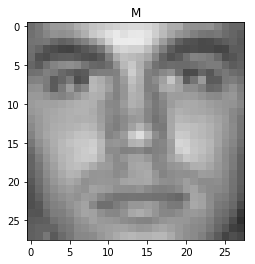

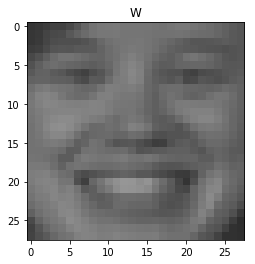

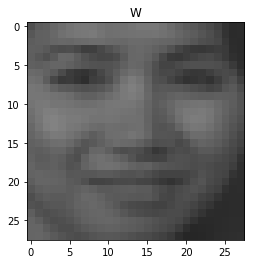

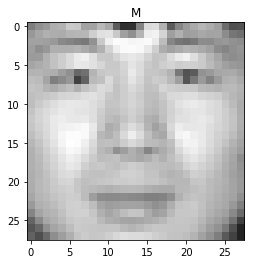

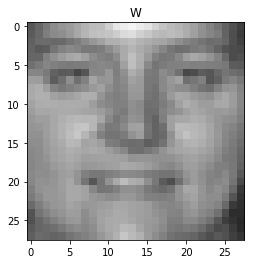

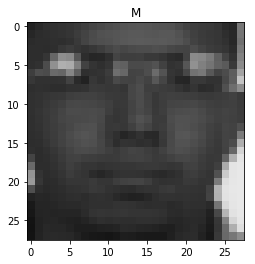

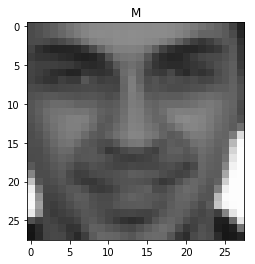

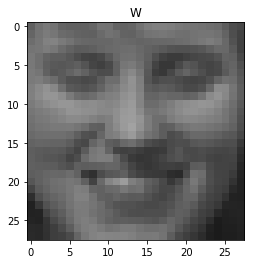

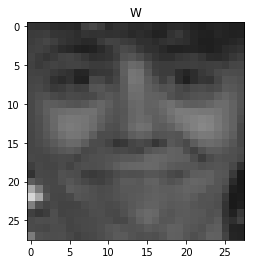

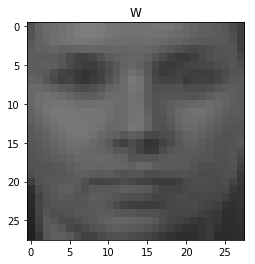

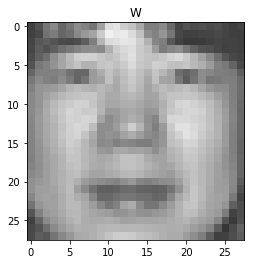

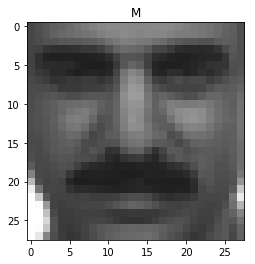

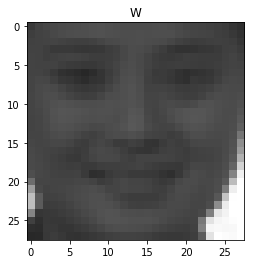

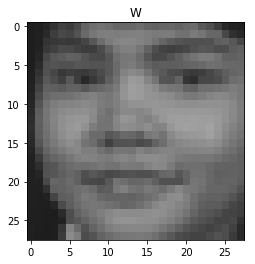

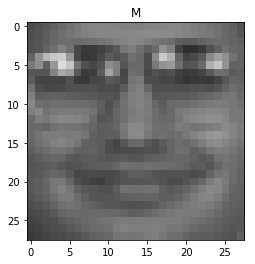

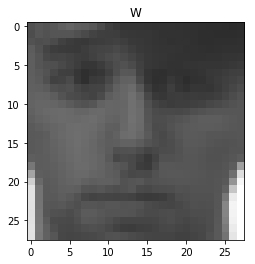

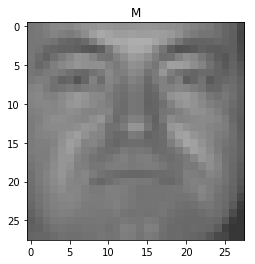

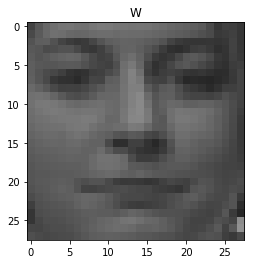

In [36]:
def show_input(input_tensor, title=''):
    try:
        image = input_tensor.permute(1, 2, 0).numpy()
        image = std * image + mean
        plt.imshow(image.clip(0, 1))
        plt.title(title)
        plt.show()
    except:
        print('ERROR in "how_input"!!!')
        

#test выведем все изображения из валидационной выборки
for x_item, y_item in zip(X_batch, y_batch):
    show_input(x_item, title=class_names[y_item])

***#15*** Соберем датасеты

In [37]:
print('train')
for X_train, y_train in train_dataloader:
    print(X_train.shape)
    print(y_train.shape)
    
print('valid')
for X_val, y_val in val_dataloader:
    print(X_val.shape)
    print(y_val.shape)
    
print('test')
for X_test, y_test in test_dataloader:
    print(X_test.shape)
    print(y_test.shape)

train
torch.Size([320, 1, 28, 28])
torch.Size([320])
valid
torch.Size([80, 1, 28, 28])
torch.Size([80])
test
torch.Size([200, 1, 28, 28])
torch.Size([200])


### Создадим свою нейронную сеть на основе архитектуры LeNet

In [38]:
class MY_LeNet(torch.nn.Module):
    def __init__(self):
        super(MY_LeNet, self).__init__()
        
        #self.conv0 = torch.nn.Conv2d(in_channels=1, out_channels=3, kernel_size=(62, 57), padding= (1,1))
        #self.act0  = torch.nn.ReLU()
        #self.pool0 = torch.nn.MaxPool2d(kernel_size=2, stride=2)
        
        
        ####
        self.conv1 = torch.nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5, padding=2)
        self.act1  = torch.nn.ReLU()
        self.pool1 = torch.nn.MaxPool2d(kernel_size=2, stride=2)
       
        self.conv2 = torch.nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5, padding=0)
        self.act2  = torch.nn.ReLU()
        self.pool2 = torch.nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.fc1   = torch.nn.Linear(5 * 5 * 16, 120)
        self.act3  = torch.nn.ReLU()
        
        self.fc2   = torch.nn.Linear(120, 64)
        self.act4  = torch.nn.ReLU()
        
        self.fc3   = torch.nn.Linear(64, 2)
    
    def forward(self, x):
        
        #x = self.conv0(x)
        #x = self.act0(x)
        #x = self.pool0(x)
        
        
        ####
        x = self.conv1(x)
        x = self.act1(x)
        x = self.pool1(x)
        
        x = self.conv2(x)
        x = self.act2(x)
        x = self.pool2(x)
        
        x = x.view(x.size(0), x.size(1) * x.size(2) * x.size(3))

        x = self.fc1(x)
        x = self.act3(x)
        x = self.fc2(x)
        x = self.act4(x)
        x = self.fc3(x)
        
        return x
    
lenet5 = MY_LeNet()

In [39]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
lenet5 = lenet5.to(device)

**#16** В качестве лосс-функции будем использовать кросс энтропию, а в качестве оптимизатора Adam

In [40]:
loss = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(lenet5.parameters(), lr=1.0e-3)

**#17** Обучим модель, сохраняя историю по значению метрики и лоссу на каждой эпохе.

In [41]:
batch_size = 40

val_accuracy_history = []
val_loss_history = []

X_test = X_test.to(device)
y_test = y_test.to(device)

for epoch in tqdm(range(250)):
    order = np.random.permutation(len(X_train))
    for start_index in range(0, len(X_train), batch_size):
        optimizer.zero_grad()
        
        batch_indexes = order[start_index:start_index+batch_size]
        
        X_batch = X_train[batch_indexes].to(device)
        y_batch = y_train[batch_indexes].to(device)
        
        preds = lenet5.forward(X_batch) 
        
        loss_value = loss(preds, y_batch)
        loss_value.backward()
        
        optimizer.step()
        
    val_preds = lenet5.forward(X_val)
    val_loss_history.append(loss(val_preds, y_val).data.cpu())
    
    accuracy = (val_preds.argmax(dim=1) == y_val).float().mean().data.cpu()
    val_accuracy_history.append(accuracy)
    
print(accuracy)

100%|████████████████████████████████████████| 250/250 [01:32<00:00,  2.70it/s]

tensor(0.9750)


значение метрики по эпохам


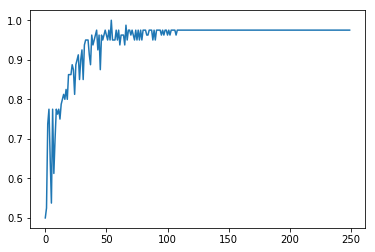

In [42]:
print('значение метрики по эпохам')
plt.plot(val_accuracy_history)
plt.show()

значение лосс-функции по эпохам


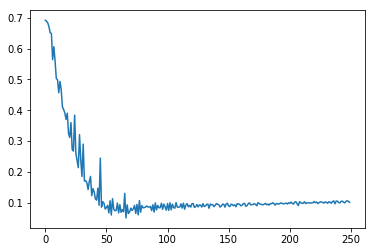

In [45]:
print('значение лосс-функции по эпохам')
plt.plot(val_loss_history)
plt.show()

In [46]:
test_preds = lenet5.forward(X_test)
print(test_preds.argmax(dim=1))
print(y_test)
print('\naccuracy на тестовой выборке: ', accuracy_score(y_test, test_preds.argmax(dim=1)))

tensor([0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0,
        0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
        0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1])
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       

In [47]:
print('Число неправильных классификаций', np.abs(y_test.numpy()-test_preds.argmax(dim=1).numpy()).sum())

Число неправильных классификаций 31


***#18*** Предсказания модели и изображения

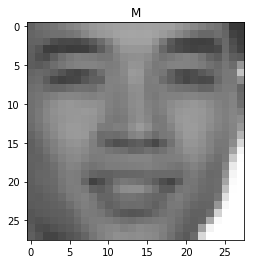

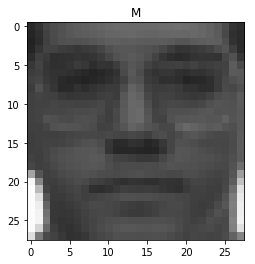

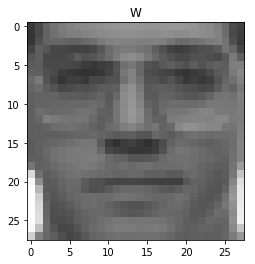

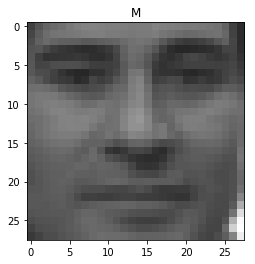

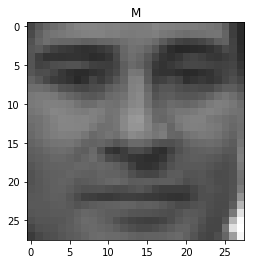

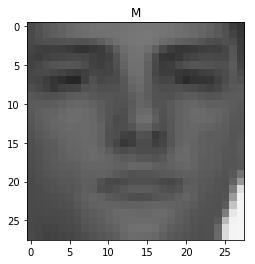

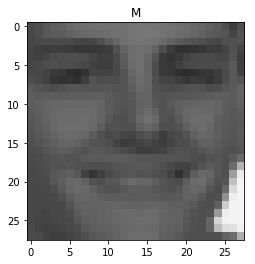

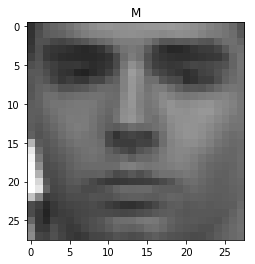

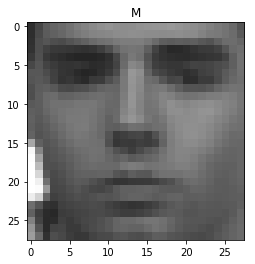

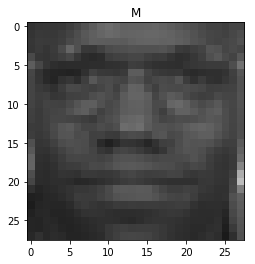

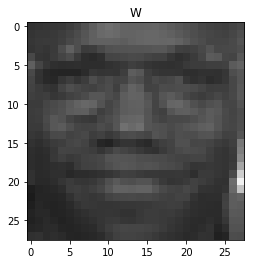

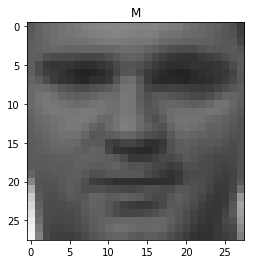

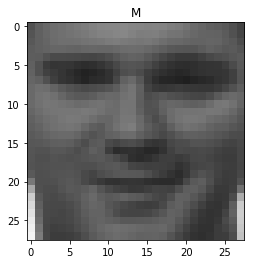

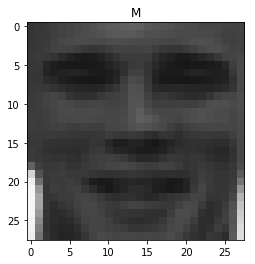

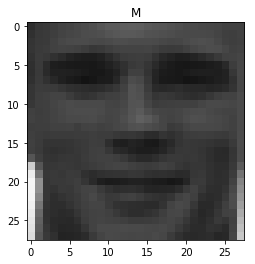

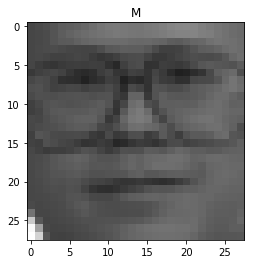

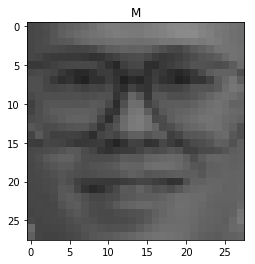

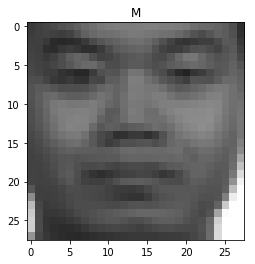

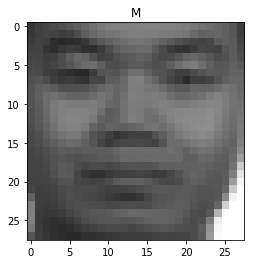

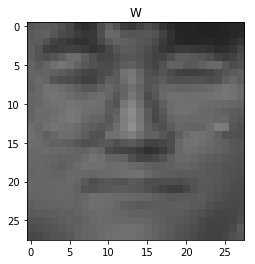

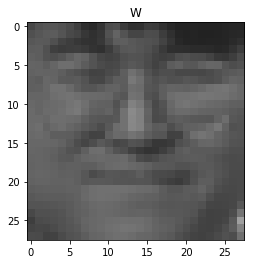

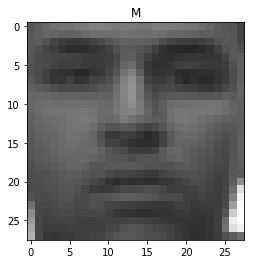

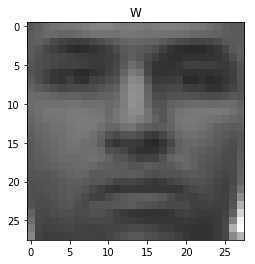

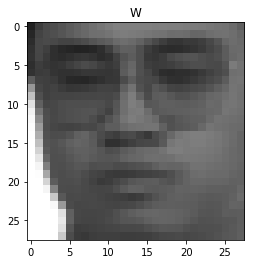

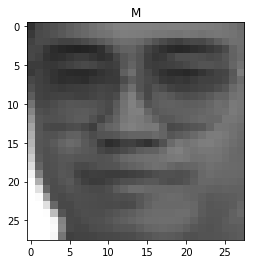

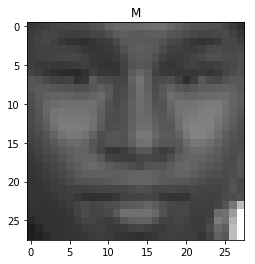

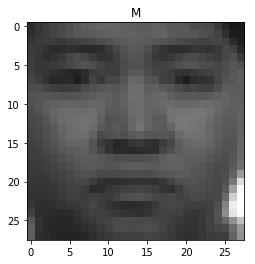

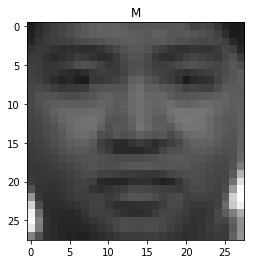

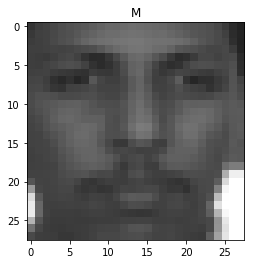

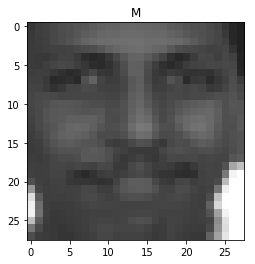

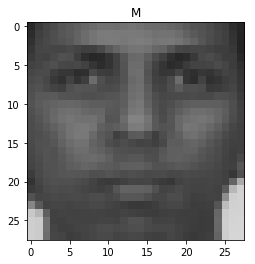

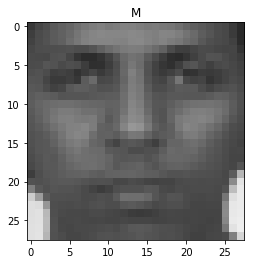

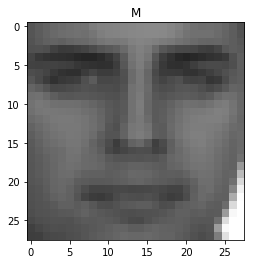

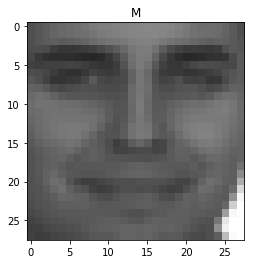

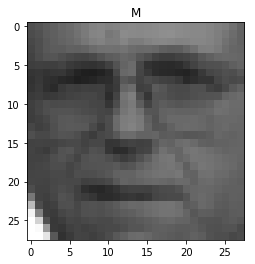

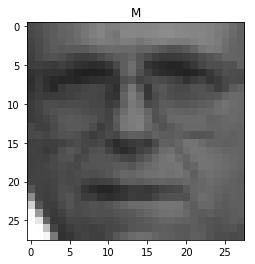

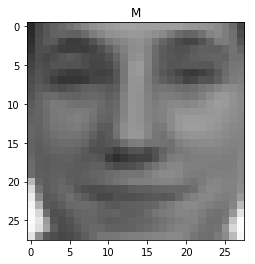

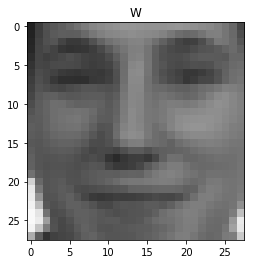

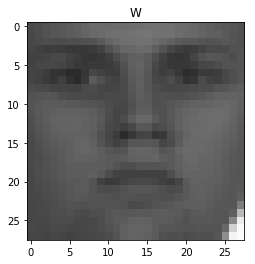

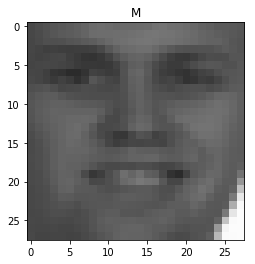

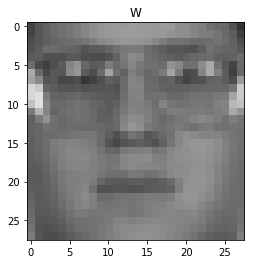

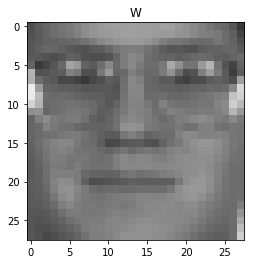

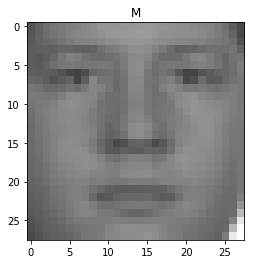

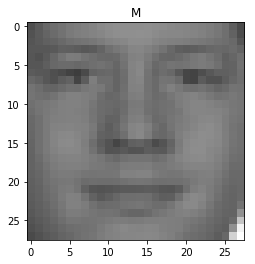

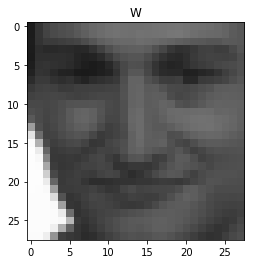

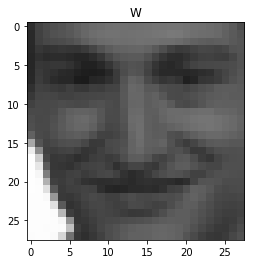

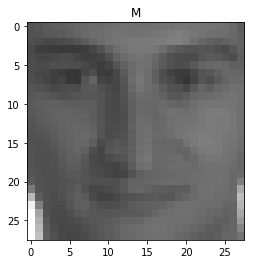

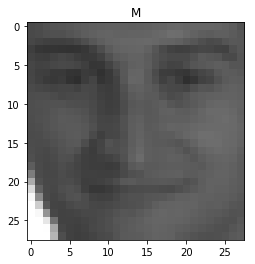

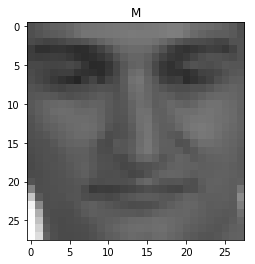

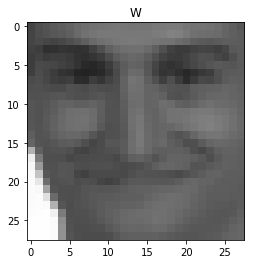

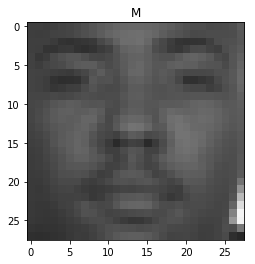

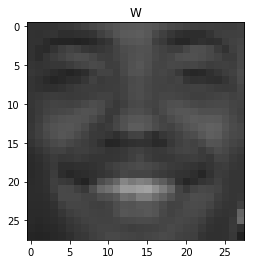

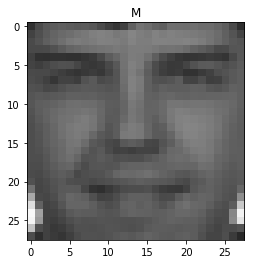

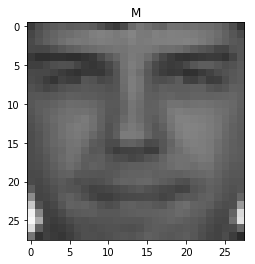

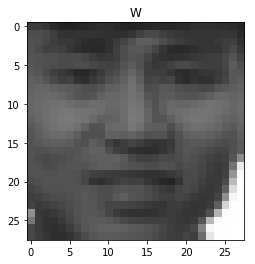

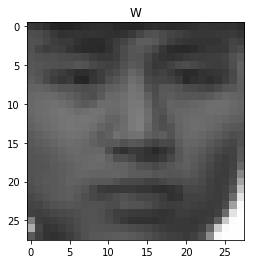

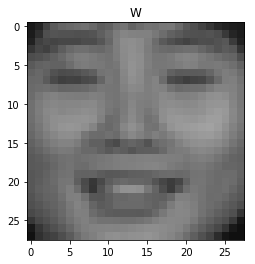

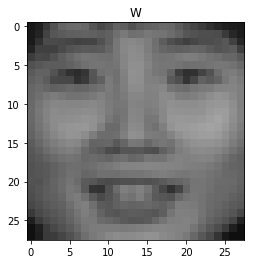

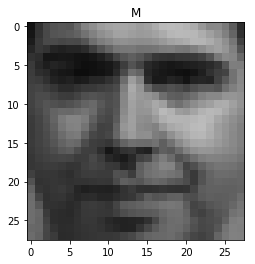

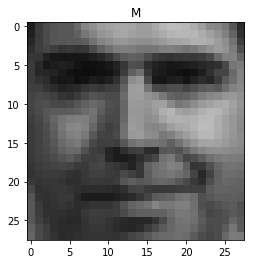

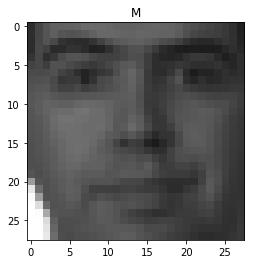

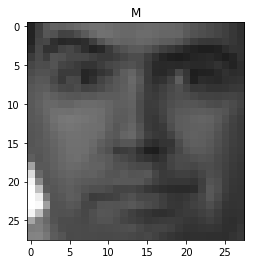

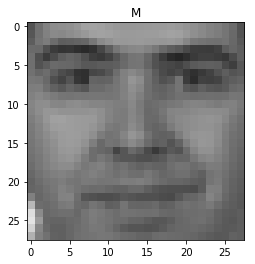

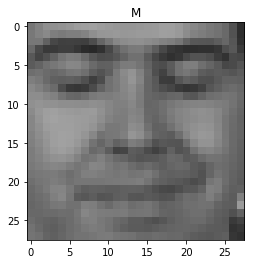

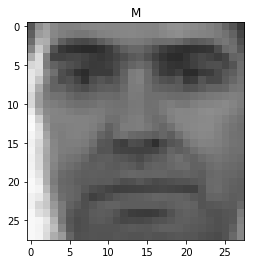

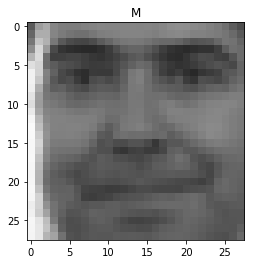

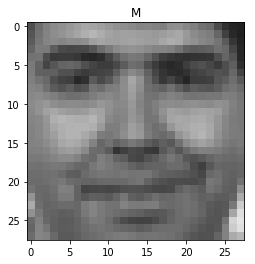

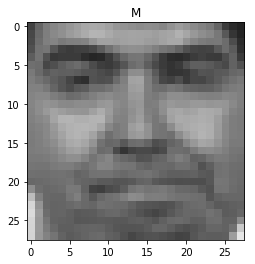

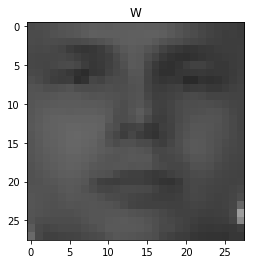

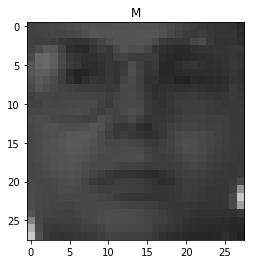

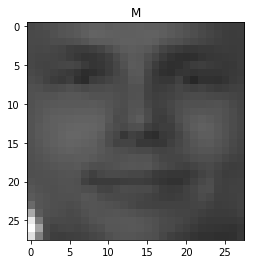

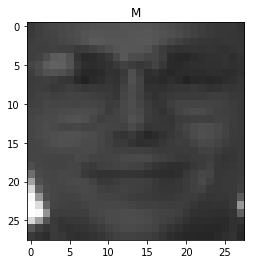

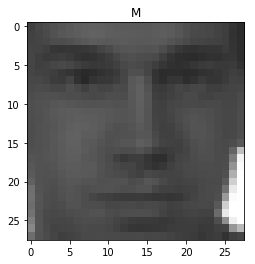

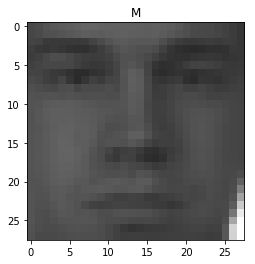

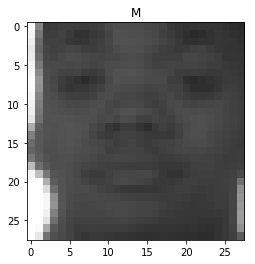

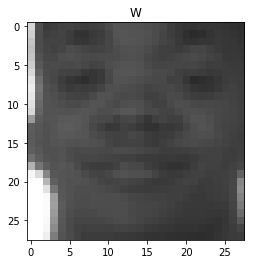

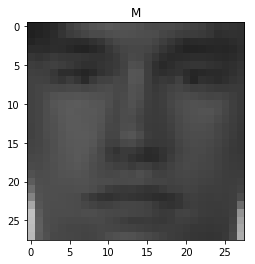

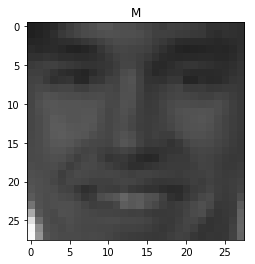

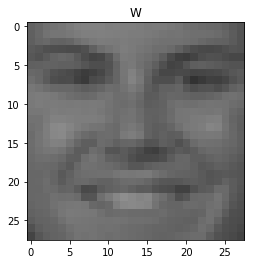

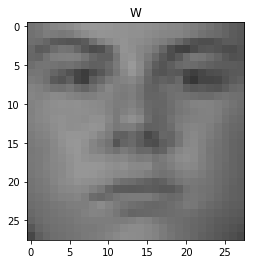

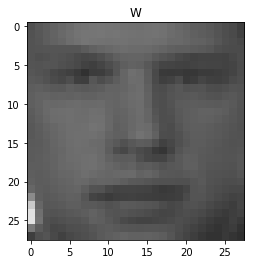

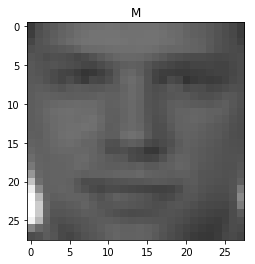

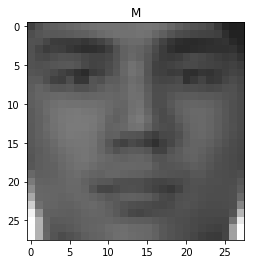

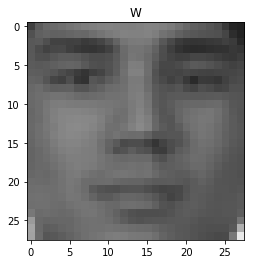

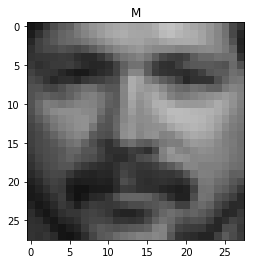

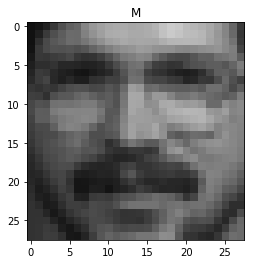

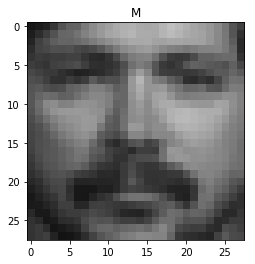

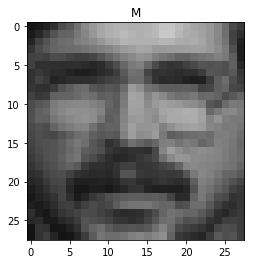

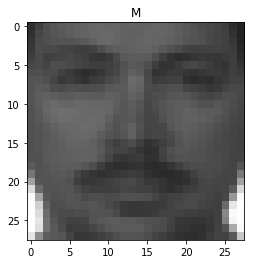

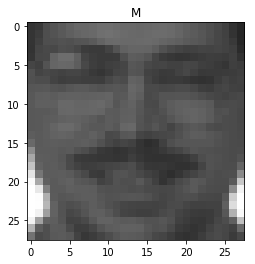

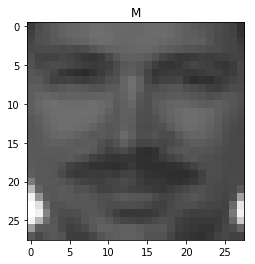

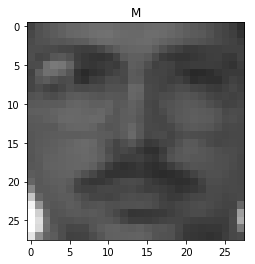

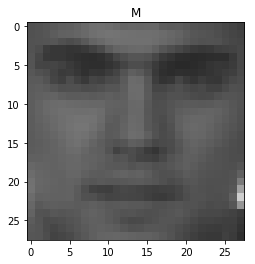

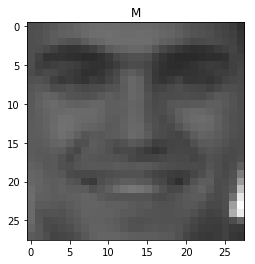

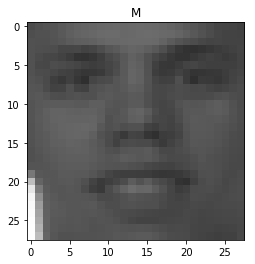

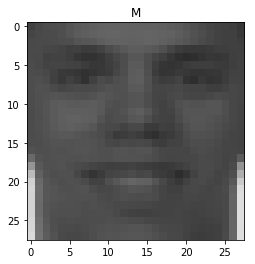

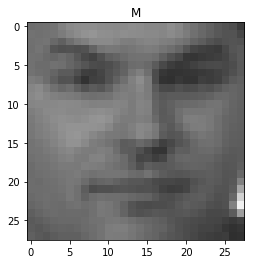

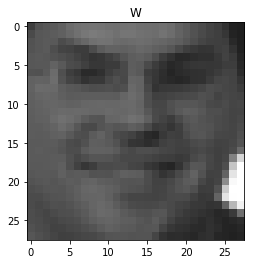

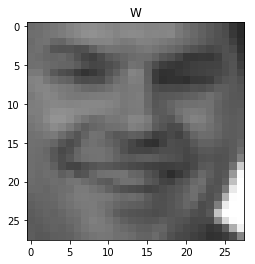

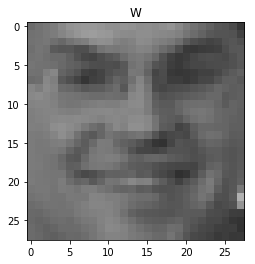

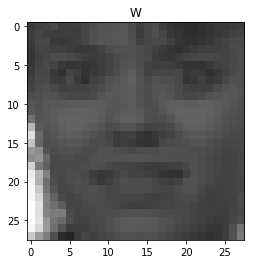

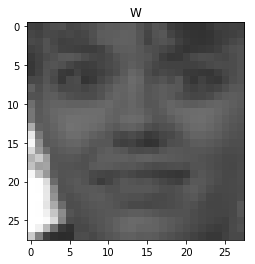

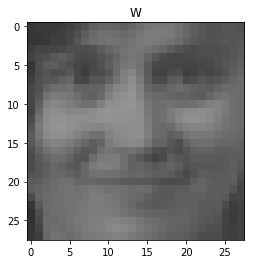

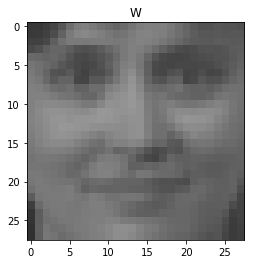

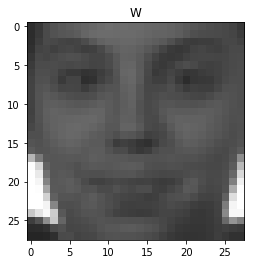

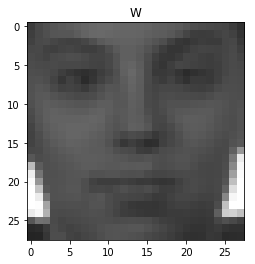

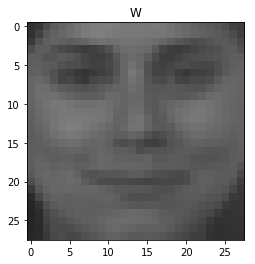

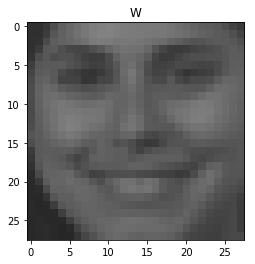

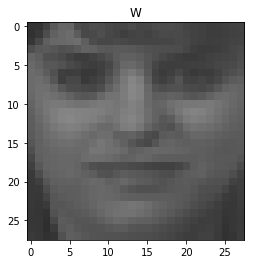

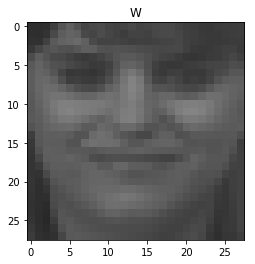

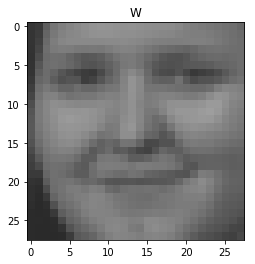

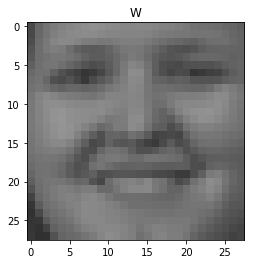

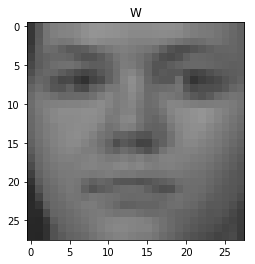

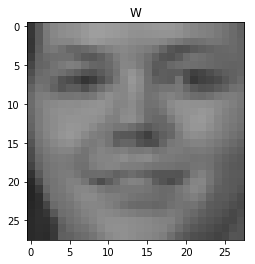

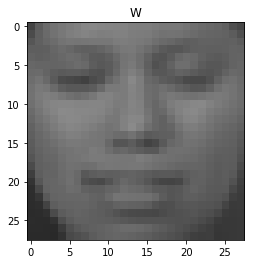

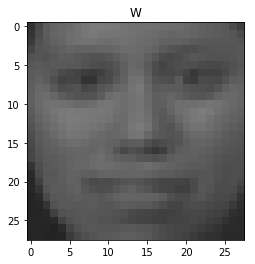

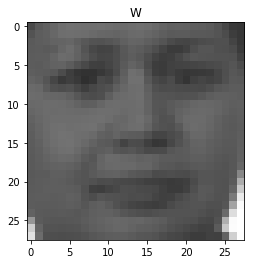

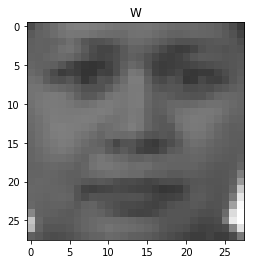

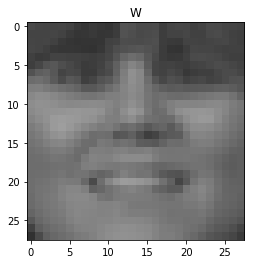

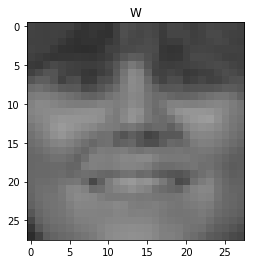

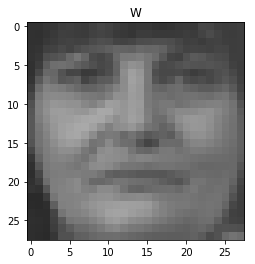

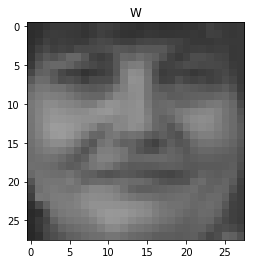

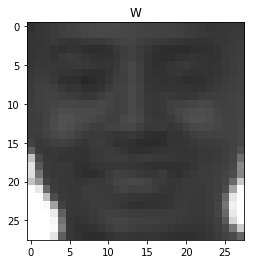

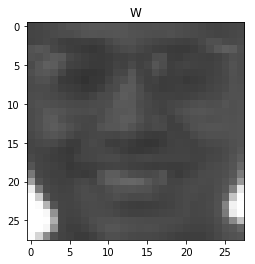

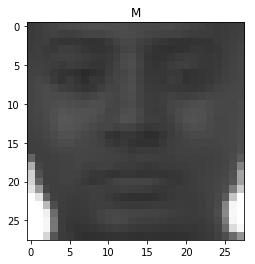

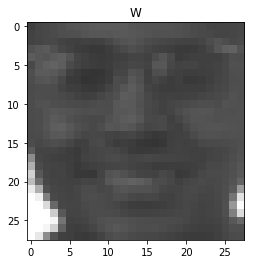

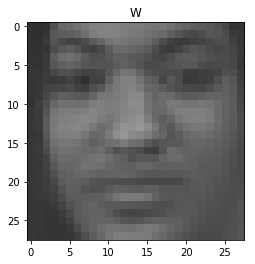

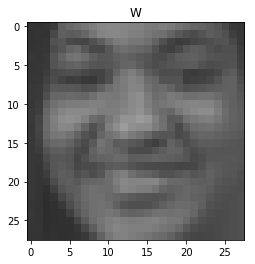

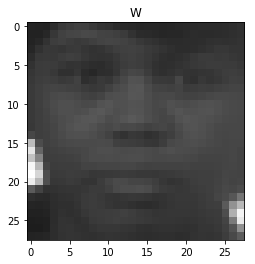

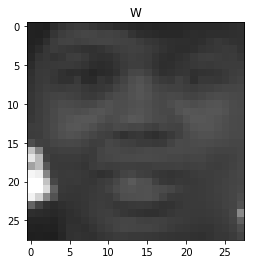

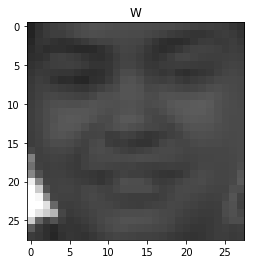

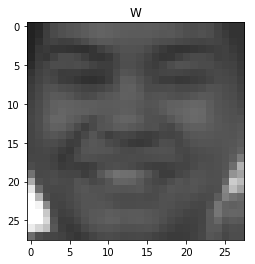

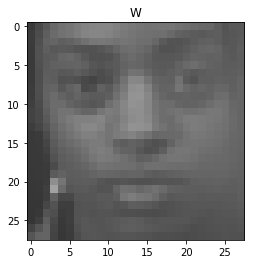

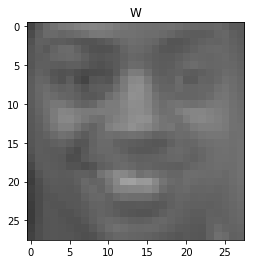

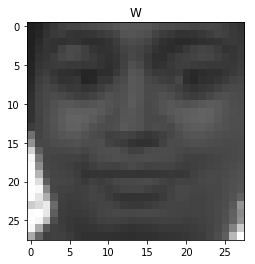

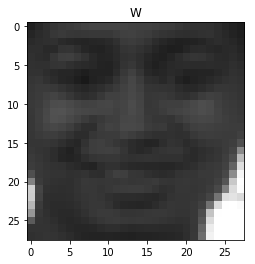

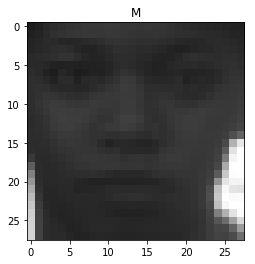

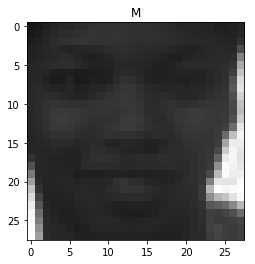

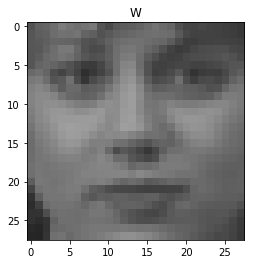

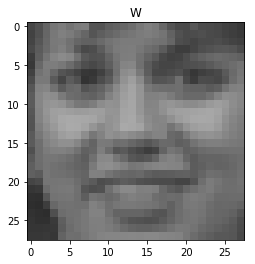

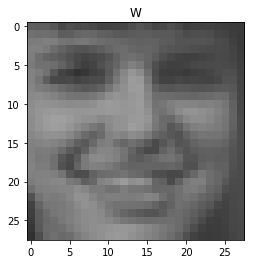

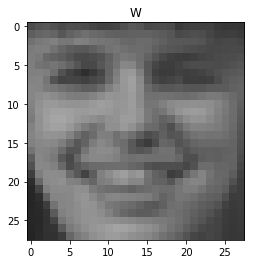

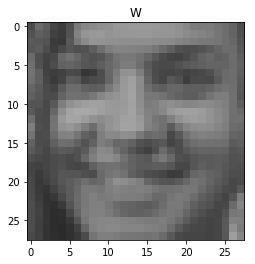

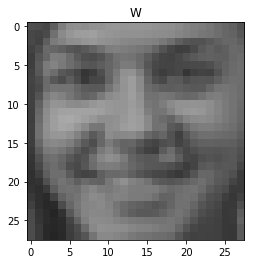

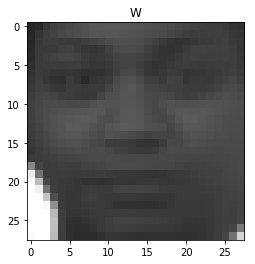

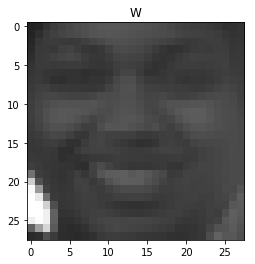

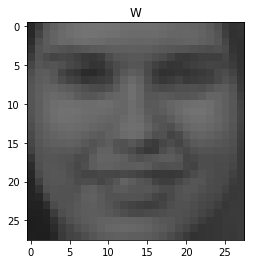

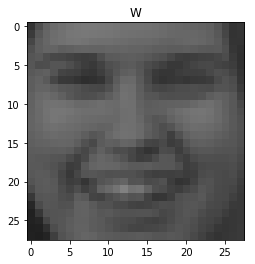

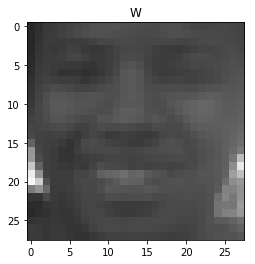

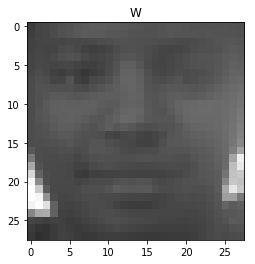

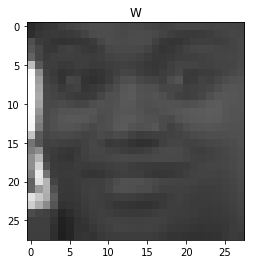

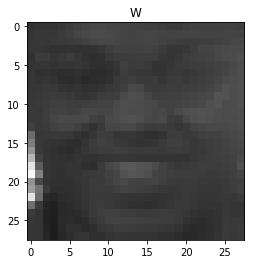

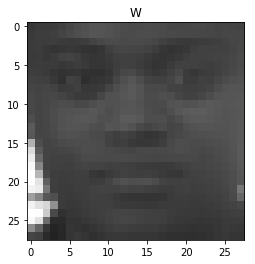

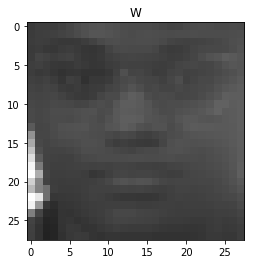

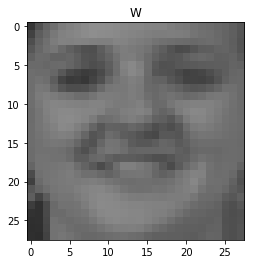

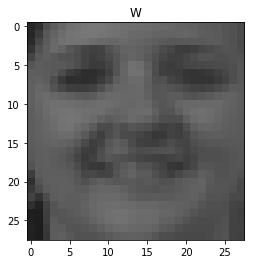

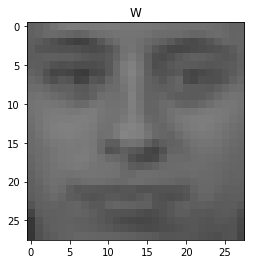

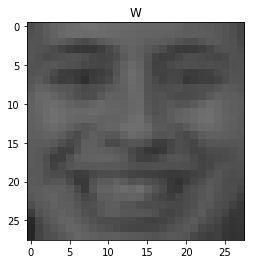

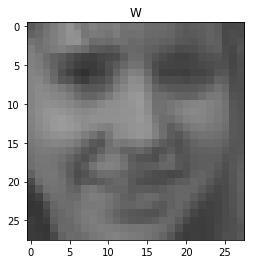

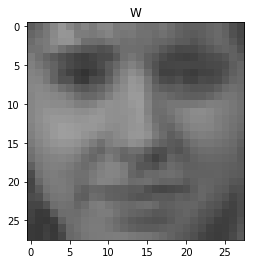

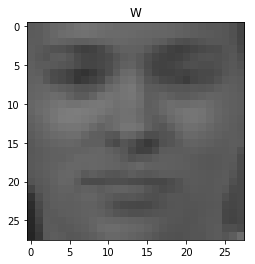

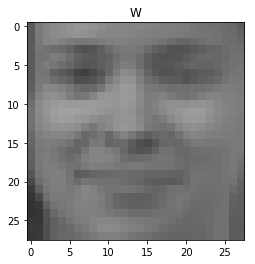

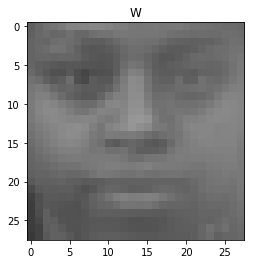

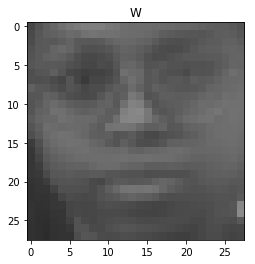

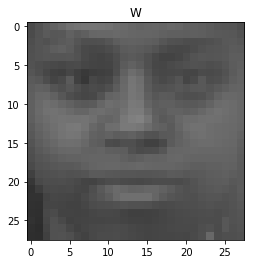

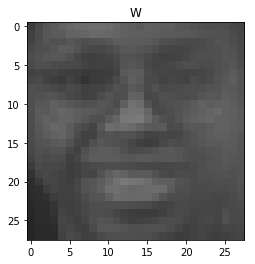

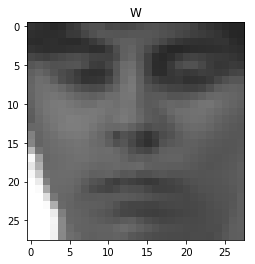

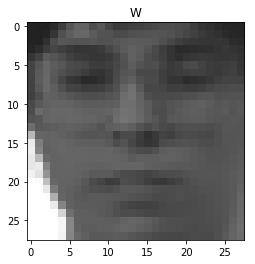

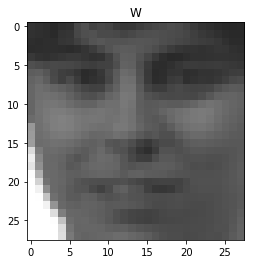

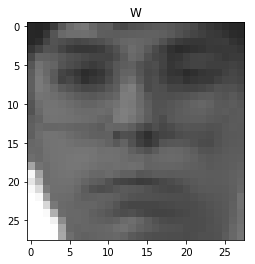

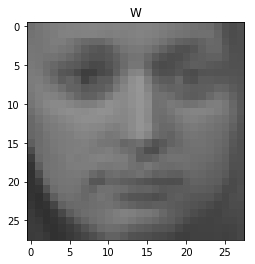

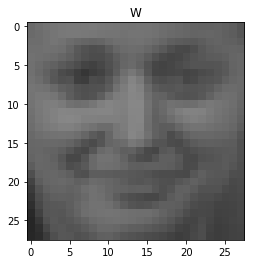

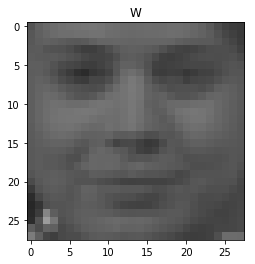

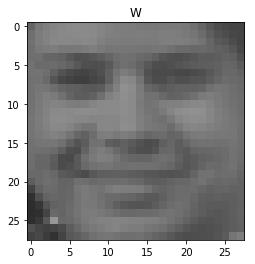

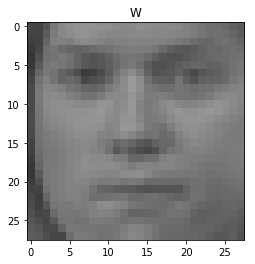

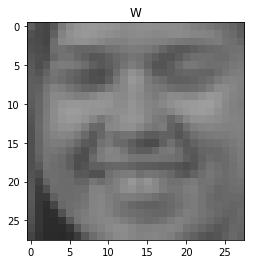

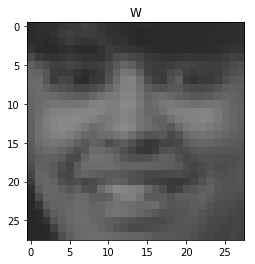

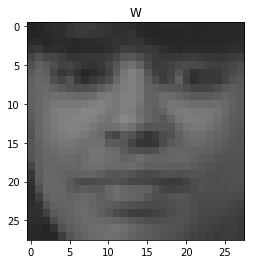

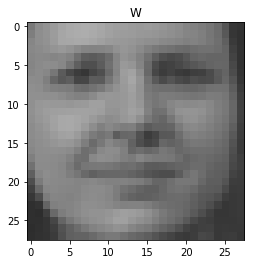

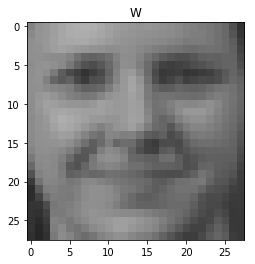

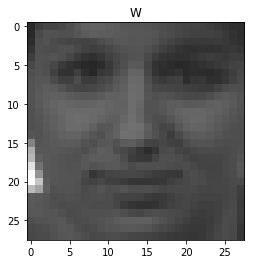

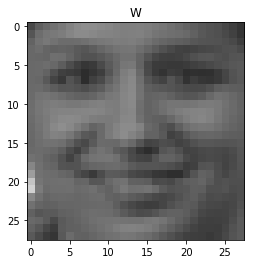

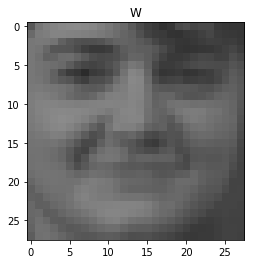

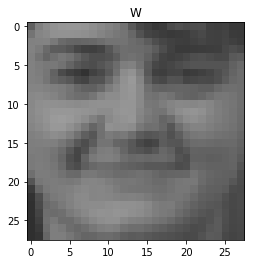

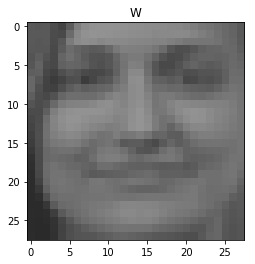

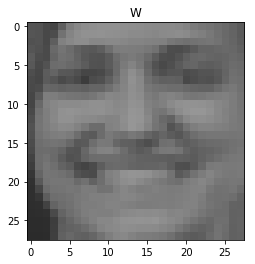

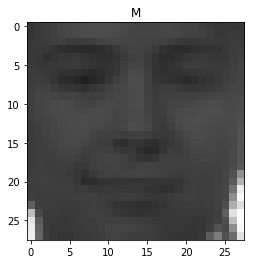

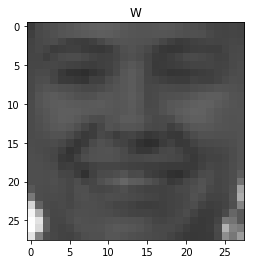

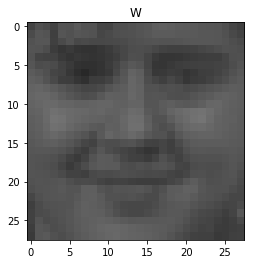

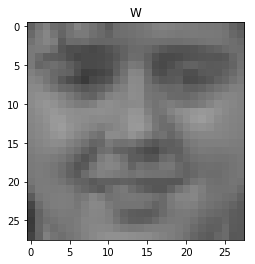

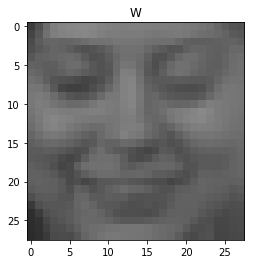

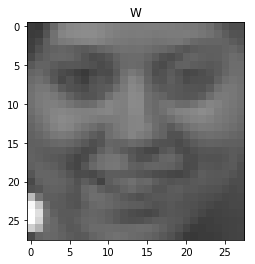

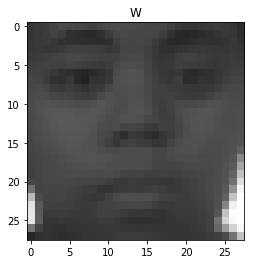

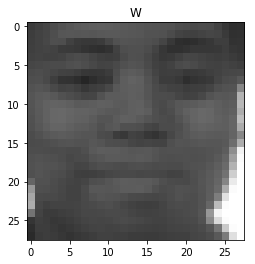

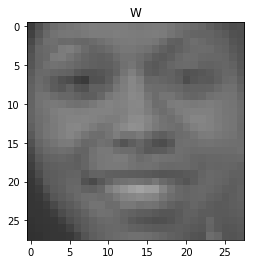

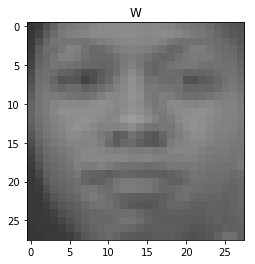

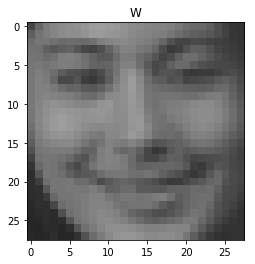

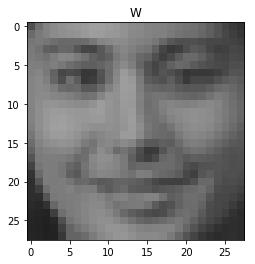

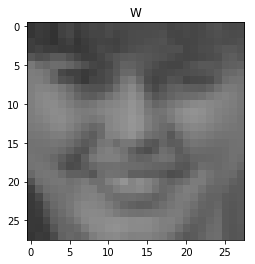

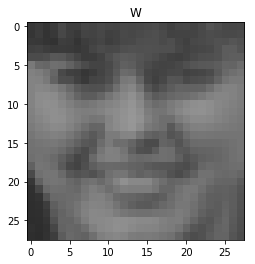

In [49]:
for x_item, y_item in zip(X_test, test_preds.argmax(dim=1)):
    show_input(x_item, title=class_names[y_item])

### Вывод  
Получили значение метрики 84.5% на тесте. С учетом того, что мы сжимали изображения до размера 28 на 28 пикселей, то результат неплохой.

# ResNet

In [50]:
train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])


train_dataset = torchvision.datasets.ImageFolder(train_dir, train_transforms)
val_dataset = torchvision.datasets.ImageFolder(val_dir, train_transforms)
test_dataset = torchvision.datasets.ImageFolder(test_dir, train_transforms)

batch_size = 20
train_dataloader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True, num_workers=batch_size)
val_dataloader = torch.utils.data.DataLoader(
    val_dataset, batch_size=batch_size, shuffle=True, num_workers=batch_size)


test_dataloader = torch.utils.data.DataLoader(
    test_dataset, batch_size=batch_size, shuffle=False, num_workers=0)

In [51]:
len(train_dataloader), len(val_dataloader), len(test_dataloader)

(16, 4, 10)

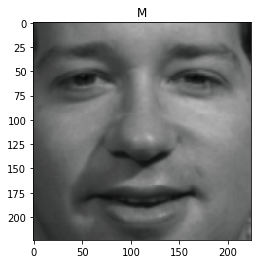

In [52]:
X_batch, y_batch = next(iter(train_dataloader))
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])
plt.title(class_names[y_batch[0]])
plt.imshow(X_batch[0].permute(1, 2, 0).numpy() * std + mean)
plt.show()

***#19.*** Напишим функцию для обучения модели

In [53]:
def train_model(model, loss, optimizer, scheduler, num_epochs):
    try:
        for epoch in range(num_epochs):
            print('Epoch {}/{}:'.format(epoch, num_epochs - 1), flush=True)

            for phase in ['train', 'val']:
                if phase == 'train':
                    dataloader = train_dataloader
                    scheduler.step()
                    model.train()  
                else:
                    dataloader = val_dataloader
                    model.eval()   

                running_loss = 0.
                running_acc = 0.

                for inputs, labels in tqdm(dataloader):
                    inputs = inputs.to(device)
                    labels = labels.to(device)

                    optimizer.zero_grad()

                    with torch.set_grad_enabled(phase == 'train'):
                        preds = model(inputs)
                        loss_value = loss(preds, labels)
                        preds_class = preds.argmax(dim=1)

                        if phase == 'train':
                            loss_value.backward()
                            optimizer.step()

                    running_loss += loss_value.item()
                    running_acc += (preds_class == labels.data).float().mean()

                epoch_loss = running_loss / len(dataloader)
                epoch_acc = running_acc / len(dataloader)

                print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc), flush=True)

        return model
    
    except:
        print('ERROR in "train_model"!!!')

***#20.*** Загрузим предобученную модель и настроем параметры обучения

In [54]:
model = models.resnet18(pretrained=True)

for param in model.parameters():
    param.requires_grad = False

model.fc = torch.nn.Linear(model.fc.in_features, 2)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

loss = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1.0e-3)


scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [55]:
train_model(model, loss, optimizer, scheduler, num_epochs=20)

Epoch 0/19:


C:\Users\admin\Anaconda3\lib\site-packages\torch\optim\lr_scheduler.py:123: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)
100%|██████████████████████████████████████████| 16/16 [02:13<00:00,  8.33s/it]

train Loss: 0.7046 Acc: 0.5344



100%|████████████████████████████████████████████| 4/4 [00:50<00:00, 12.50s/it]

val Loss: 0.6862 Acc: 0.5375
Epoch 1/19:



100%|██████████████████████████████████████████| 16/16 [02:11<00:00,  8.23s/it]

train Loss: 0.5731 Acc: 0.6969



100%|████████████████████████████████████████████| 4/4 [00:49<00:00, 12.34s/it]

val Loss: 0.6015 Acc: 0.6625
Epoch 2/19:



100%|██████████████████████████████████████████| 16/16 [02:18<00:00,  8.64s/it]

train Loss: 0.4763 Acc: 0.7594



100%|████████████████████████████████████████████| 4/4 [00:49<00:00, 12.39s/it]

val Loss: 0.5808 Acc: 0.6625
Epoch 3/19:



100%|██████████████████████████████████████████| 16/16 [02:24<00:00,  9.00s/it]

train Loss: 0.4354 Acc: 0.8219



100%|████████████████████████████████████████████| 4/4 [00:57<00:00, 14.27s/it]

val Loss: 0.4392 Acc: 0.8000
Epoch 4/19:



100%|██████████████████████████████████████████| 16/16 [02:30<00:00,  9.43s/it]

train Loss: 0.3806 Acc: 0.8500



100%|████████████████████████████████████████████| 4/4 [00:56<00:00, 14.05s/it]

val Loss: 0.4104 Acc: 0.7875
Epoch 5/19:



100%|██████████████████████████████████████████| 16/16 [02:34<00:00,  9.63s/it]

train Loss: 0.3476 Acc: 0.8906



100%|████████████████████████████████████████████| 4/4 [00:54<00:00, 13.75s/it]

val Loss: 0.3471 Acc: 0.9000
Epoch 6/19:



100%|██████████████████████████████████████████| 16/16 [02:30<00:00,  9.39s/it]

train Loss: 0.3203 Acc: 0.8875



100%|████████████████████████████████████████████| 4/4 [00:57<00:00, 14.29s/it]

val Loss: 0.3384 Acc: 0.8750
Epoch 7/19:



100%|██████████████████████████████████████████| 16/16 [02:29<00:00,  9.37s/it]

train Loss: 0.3022 Acc: 0.9031



100%|████████████████████████████████████████████| 4/4 [00:56<00:00, 14.25s/it]

val Loss: 0.3351 Acc: 0.8875
Epoch 8/19:



100%|██████████████████████████████████████████| 16/16 [02:33<00:00,  9.62s/it]

train Loss: 0.3008 Acc: 0.9125



100%|████████████████████████████████████████████| 4/4 [00:56<00:00, 14.11s/it]

val Loss: 0.3352 Acc: 0.8875
Epoch 9/19:



100%|██████████████████████████████████████████| 16/16 [02:28<00:00,  9.31s/it]

train Loss: 0.3048 Acc: 0.9062



100%|████████████████████████████████████████████| 4/4 [00:56<00:00, 14.18s/it]

val Loss: 0.3344 Acc: 0.8750
Epoch 10/19:



100%|██████████████████████████████████████████| 16/16 [02:28<00:00,  9.25s/it]

train Loss: 0.3063 Acc: 0.8906



100%|████████████████████████████████████████████| 4/4 [00:57<00:00, 14.36s/it]

val Loss: 0.3325 Acc: 0.9000
Epoch 11/19:



100%|██████████████████████████████████████████| 16/16 [02:32<00:00,  9.52s/it]

train Loss: 0.3140 Acc: 0.8906



100%|████████████████████████████████████████████| 4/4 [00:55<00:00, 13.97s/it]

val Loss: 0.3282 Acc: 0.9000
Epoch 12/19:



100%|██████████████████████████████████████████| 16/16 [02:30<00:00,  9.42s/it]

train Loss: 0.2966 Acc: 0.9031



100%|████████████████████████████████████████████| 4/4 [00:55<00:00, 13.98s/it]

val Loss: 0.3294 Acc: 0.8625
Epoch 13/19:



100%|██████████████████████████████████████████| 16/16 [02:29<00:00,  9.36s/it]

train Loss: 0.3085 Acc: 0.8906



100%|████████████████████████████████████████████| 4/4 [00:54<00:00, 13.65s/it]

val Loss: 0.3279 Acc: 0.8625
Epoch 14/19:



100%|██████████████████████████████████████████| 16/16 [02:32<00:00,  9.53s/it]

train Loss: 0.3218 Acc: 0.8906



100%|████████████████████████████████████████████| 4/4 [00:56<00:00, 14.10s/it]

val Loss: 0.3303 Acc: 0.8500
Epoch 15/19:



100%|██████████████████████████████████████████| 16/16 [02:29<00:00,  9.33s/it]

train Loss: 0.3080 Acc: 0.8812



100%|████████████████████████████████████████████| 4/4 [00:54<00:00, 13.71s/it]

val Loss: 0.3271 Acc: 0.8750
Epoch 16/19:



100%|██████████████████████████████████████████| 16/16 [02:30<00:00,  9.42s/it]

train Loss: 0.2904 Acc: 0.9000



100%|████████████████████████████████████████████| 4/4 [01:09<00:00, 17.45s/it]

val Loss: 0.3253 Acc: 0.8875
Epoch 17/19:



100%|██████████████████████████████████████████| 16/16 [02:23<00:00,  8.96s/it]

train Loss: 0.3067 Acc: 0.8750



100%|████████████████████████████████████████████| 4/4 [00:51<00:00, 12.78s/it]

val Loss: 0.3272 Acc: 0.9000
Epoch 18/19:



100%|██████████████████████████████████████████| 16/16 [02:12<00:00,  8.25s/it]

train Loss: 0.3117 Acc: 0.8875



100%|████████████████████████████████████████████| 4/4 [00:49<00:00, 12.29s/it]

val Loss: 0.3275 Acc: 0.8750
Epoch 19/19:



100%|██████████████████████████████████████████| 16/16 [02:16<00:00,  8.53s/it]

train Loss: 0.3027 Acc: 0.8969



100%|████████████████████████████████████████████| 4/4 [00:50<00:00, 12.60s/it]

val Loss: 0.3277 Acc: 0.8750


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

***#21.*** Проверим качество на тесте

In [56]:
model.eval()

test_predictions = []
y_true = []

for inputs, labels in tqdm(test_dataloader):
    inputs = inputs.to(device)
    labels = labels.to(device)
    with torch.set_grad_enabled(False):
        preds = model(inputs)
    test_predictions.append(
        torch.nn.functional.softmax(preds, dim=1)[:,1].data.cpu().numpy())
    y_true.append(labels.numpy())
    #test_img_paths.extend(paths)
    
test_predictions = np.concatenate(test_predictions)
y_true = np.concatenate(y_true)
y_true

100%|██████████████████████████████████████████| 10/10 [01:12<00:00,  7.26s/it]


array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1], dtype=int64)

In [59]:
ans = np.array(list(map(lambda x: 1 if x > 0.5 else 0, test_predictions)))
print(ans)
print('Число неправильных классификаций', np.abs(y_true-ans).sum())

[0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0
 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 1 0 0 0 1 1 0 0 0 1 0 0
 0 0 1 0 1 1 0 0 0 0 1 1 0 0 0 1 1 0 0 1 0 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 0 0 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Число неправильных классификаций 27


In [60]:
print('\naccuracy на тестовой выборке: ', accuracy_score(y_true, ans))


accuracy на тестовой выборке:  0.865


### Вывод  
Получили значение метрики 86.5% на тесте. Дообученая сеть ResNet18 показала лучший результат.

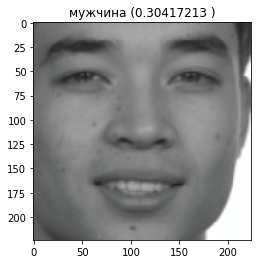

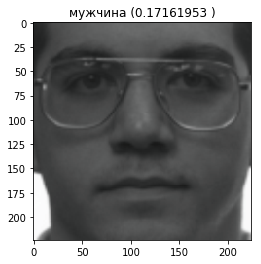

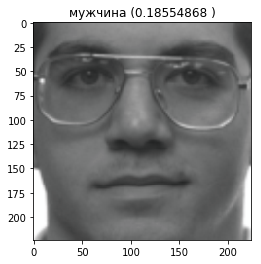

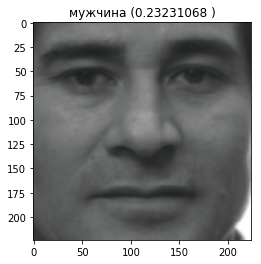

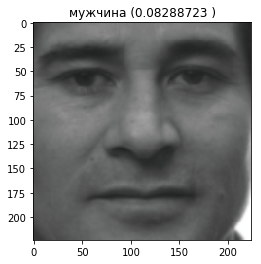

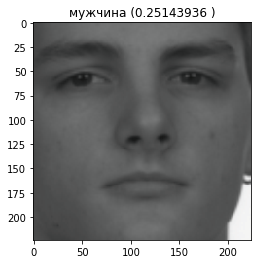

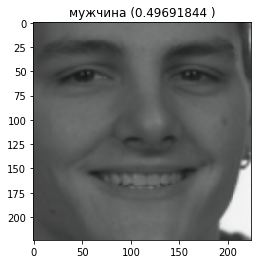

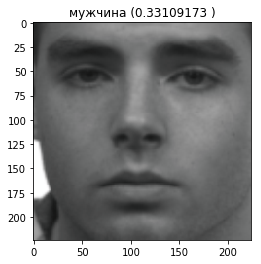

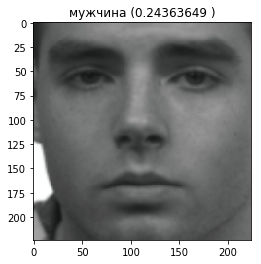

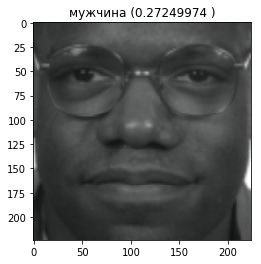

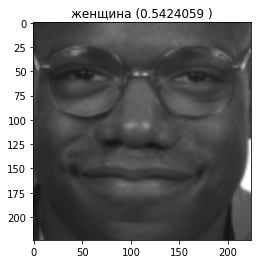

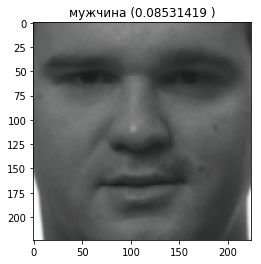

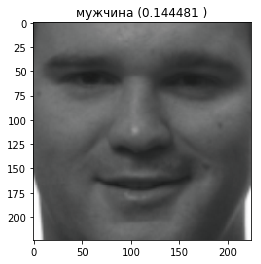

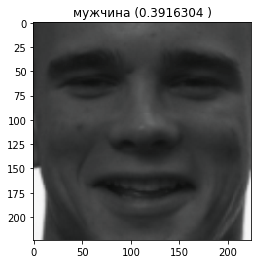

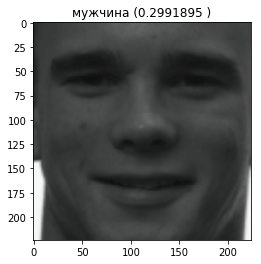

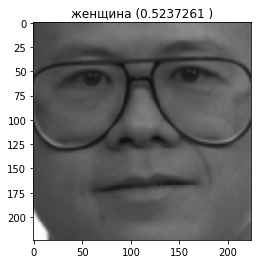

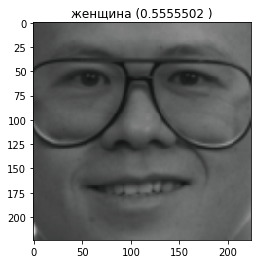

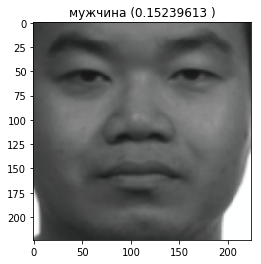

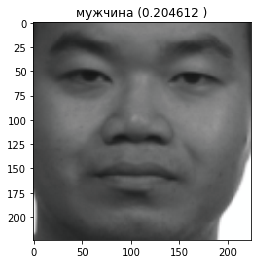

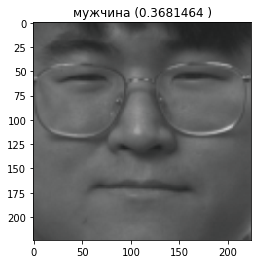

In [61]:
#результаты предсказания на одном батче
inputs, labels = next(iter(test_dataloader))

for img, pred in zip(inputs, test_predictions):
    if pred < 0.5:
        sex = 'мужчина'
    else:
        sex = 'женщина'
        
    show_input(img, title=sex+' ('+str(pred)+' )')